In [1]:
import numpy as np
from PIL import Image
import cv2
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import matplotlib.pyplot as plt
#from pyquaternion import Quaternion

from data_helper import UnlabeledDataset, LabeledDataset

In [5]:
import kornia
from data_loading import get_loaders


In [3]:
M_matrices = torch.tensor([
    # CAM_FRONT_LEFT
    [[-6.92946073e-02, -1.17143003e+00,  1.64122408e+02],
       [-1.33781874e-14, -1.67019853e+00,  2.34084846e+02],
       [-7.00394603e-17, -7.63146706e-03,  1.00000000e+00]], 
    # CAM_FRONT
    [[-6.92636526e-02, -1.17089785e+00,  1.64264194e+02],
       [-1.12965193e-14, -1.66944201e+00,  2.34140507e+02],
       [-5.76795556e-17, -7.62799727e-03,  1.00000000e+00]],
    # CAM_FRONT_RIGHT
    [[-7.02452787e-02, -1.17762492e+00,  1.64369634e+02],
       [-2.27595720e-14, -1.67903365e+00,  2.34318471e+02],
       [-1.16009632e-16, -7.67182090e-03,  1.00000000e+00]],
    # CAM_BACK_LEFT
    [[-6.94775392e-02, -1.17675499e+00,  1.64135286e+02],
       [-1.19904087e-14, -1.67779415e+00,  2.34164782e+02],
       [-5.78963960e-17, -7.66615368e-03,  1.00000000e+00]],
    # CAM_BACK
    [[-6.82085369e-02, -1.16228084e+00,  1.64011808e+02],
       [-1.23234756e-14, -1.65715610e+00,  2.33912863e+02],
       [-6.39679282e-17, -7.57186452e-03,  1.00000000e+00]],
    # CAM_BACK_RIGHT
    [[-6.91003275e-02, -1.16814423e+00,  1.63997347e+02],
       [-1.59872116e-14, -1.66551463e+00,  2.34087152e+02],
       [-8.30498864e-17, -7.61006318e-03,  1.00000000e+00]]
       ])

In [47]:
example_folder = 'data/scene_122/sample_0'
#example_folder = '/Users/nhuang37/Desktop/NYU DS/Yr 2 Sem2/DL/Final project/DLSP20-Project/data/scene_121/sample_0'
image_folder = 'data'
annotation_csv = 'data/annotation.csv'

In [222]:
from torchvision import transforms

#get train, valid
unlabeled_scene_index = np.arange(106)

# transform = transforms.Compose([
#                 transforms.ToTensor(),
#                 transforms.Normalize((0.548, 0.597, 0.630),
#                                      (0.339, 0.340, 0.342))
#                 ])
transform = torchvision.transforms.ToTensor()
unlabeled_trainset = UnlabeledDataset(image_folder=image_folder, scene_index=unlabeled_scene_index, first_dim='sample', transform=transform)
trainloader = torch.utils.data.DataLoader(unlabeled_trainset, batch_size=2, shuffle=True, num_workers=2)

In [275]:
sample = iter(trainloader).next()

In [276]:
sample.shape

torch.Size([2, 6, 3, 256, 306])

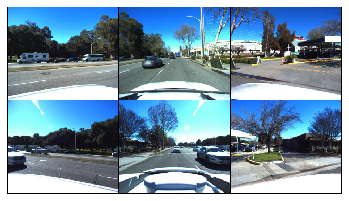

In [277]:
plt.imshow(torchvision.utils.make_grid(sample[1], nrow=3).numpy().transpose(1, 2, 0))
plt.axis('off');

In [278]:
M_rotations[0].shape,  M_matrices[0].shape

(torch.Size([1, 2, 3]), torch.Size([3, 3]))

In [372]:
BEV_imgs = []
Rot_imgs = []
for i in range(6):
    #get a batch of *same* view images
    img_batch = sample[:,i,:,:,:]
    img_warp = kornia.warp_perspective(img_batch, M_matrices[i].unsqueeze(0).repeat(len(sample), 1,1),
                                       dsize=(219, 306))
    BEV_imgs.append(img_warp)

    img_rotated = kornia.warp_affine(img_warp, M_rotations[i].repeat(len(sample), 1,1), dsize=(219, 306))
    Rot_imgs.append(img_rotated)
BEV_imgs = torch.cat(BEV_imgs,dim=0)
Rot_imgs = torch.cat(Rot_imgs,dim=0).view(6,2,3,219,306)

In [373]:
Rot_imgs[0].shape

torch.Size([2, 3, 219, 306])

In [374]:
#translation pixels
s = 55
w= 55
#black canvas
canvas = torch.zeros((2,3,438,612)) #[batch_size, 3, 438,612]
canvas[:,:,0:219,153:459] = Rot_imgs[1]
canvas[:,:,219:,153:459] = Rot_imgs[4]

#top left
canvas[:,:,(0+s):(219+s),(0+w):(306+w)] = torch.max(Rot_imgs[0], canvas[:,:,(0+s):(219+s),(0+w):(306+w)])
#top right
canvas[:,:,(0+s):(219+s),(306-w):(-w)] = torch.max(Rot_imgs[2], canvas[:,:,(0+s):(219+s),(306-w):(-w)])
#botton right
canvas[:,:,(219-s):(-s),(306-w):(-w)] = torch.max(Rot_imgs[5], canvas[:,:,(219-s):(-s),(306-w):(-w)])
#bottom left
canvas[:,:,(219-s):(-s),(0+w):(306+w)] = torch.max(Rot_imgs[3], canvas[:,:,(219-s):(-s),(0+w):(306+w)])


In [375]:
#crop the output
crop_fn = kornia.augmentation.CenterCrop(size=438)
canvas = crop_fn(canvas)

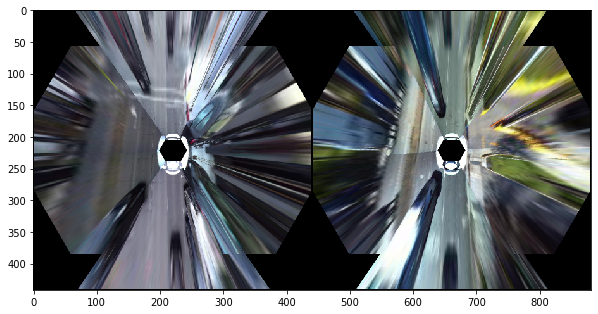

In [376]:
plt.figure(figsize = (10,6))

plt.imshow(torchvision.utils.make_grid(canvas, nrow=2).numpy().transpose(1, 2, 0))

In [325]:
a = torch.nn.Parameter(torch.ones(1)) 
print(type(int(a.item())))

<class 'int'>


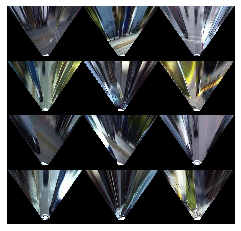

In [287]:
plt.imshow(torchvision.utils.make_grid(BEV_imgs, nrow=3).numpy().transpose(1, 2, 0))
plt.axis('off');

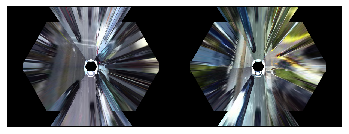

In [290]:
plt.imshow(torchvision.utils.make_grid(canvas, nrow=2).numpy().transpose(1, 2, 0))
plt.axis('off');
#plt.imshow(canvas[0].numpy().transpose(1, 2, 0))

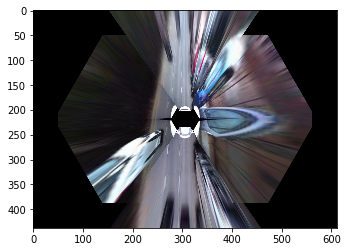

In [191]:
#new grid: 2w, 2h - 438, 612; black canvas
canvas = torch.zeros((3,438,612))
#two bases: front and back
canvas[:,0:219,153:459] = img_rotated[1]
canvas[:,219:,153:459] = img_rotated[4]
#translation pixels
s = 50
w= 50
#top left
canvas[:,(0+s):(219+s),(0+w):(306+w)] = torch.max(img_rotated[0], canvas[:,(0+s):(219+s),(0+w):(306+w)])
#top right
canvas[:,(0+s):(219+s),(306-w):(-w)] = torch.max(img_rotated[2], canvas[:,(0+s):(219+s),(306-w):(-w)])
#botton right
canvas[:,(219-s):(-s),(306-w):(-w)] = torch.max(img_rotated[5], canvas[:,(219-s):(-s),(306-w):(-w)])
#bottom left
canvas[:,(219-s):(-s),(0+w):(306+w)] = torch.max(img_rotated[3], canvas[:,(219-s):(-s),(0+w):(306+w)])
plt.imshow(canvas.numpy().transpose(1, 2, 0))


In [320]:
x = torch.ones((2,3,4))
#agg = torch.zeros(x.size*2)#torch.zeros((3,x.shape[0],x.shape[1],x.shape[2]))
w, h = x.shape[0], x.shape[1]
print(w, h)
#print()
#M_rotations[0].shape

2 3


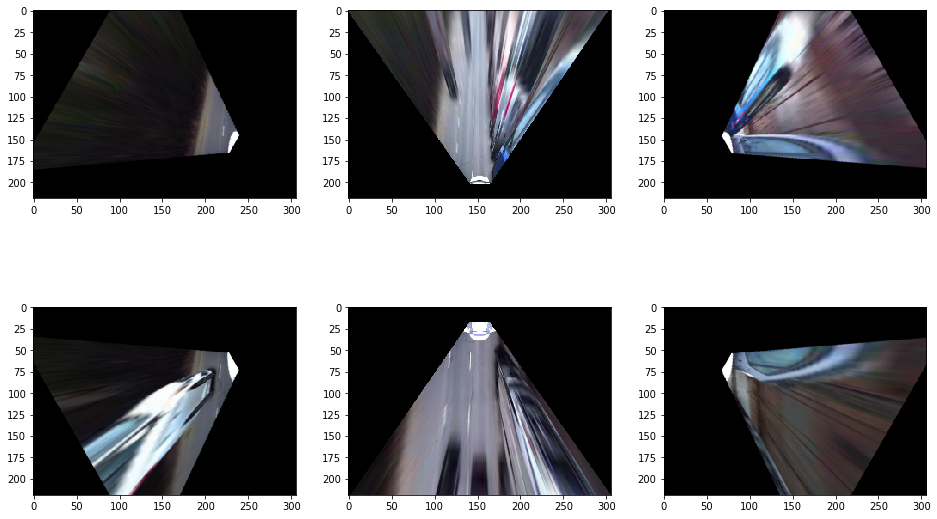

In [133]:
#one-off code to learn M_rotations (6 2x3 tensors for 6 views)
# M_rotations = []
# img_rotated = []
# alphas = [60.0, 0, -60.0, 120.0, -180.0, -120.0]

# fig, axs = plt.subplots(2, 3, figsize=(16, 10))
# axs = axs.ravel()

# for i,(alpha,img) in enumerate(zip(alphas,BEV_imgs)):
#     #perform rotation
#     angle = torch.ones(1) * alpha

#     # define the rotation center
#     center = torch.ones(1, 2)
#     center[..., 0] = img.shape[3] / 2  # x
#     center[..., 1] = img.shape[2] / 2  # y

#     # define the scale factor
#     scale = torch.ones(1)

#     # compute the transformation matrix
#     M_ro = kornia.get_rotation_matrix2d(center, angle, scale)

#     # apply the transformation to original image
#     _, _, h, w = img.shape
#     img_warped = kornia.warp_affine(img, M_ro, dsize=(h, w))
    
#     # store values
#     M_rotations.append(M_ro)
#     img_rotated.append(img_warped)

#     # convert back to numpy
#     image_warped = kornia.tensor_to_image(img_warped[0])
#     axs[i].imshow(image_warped)

## Front View

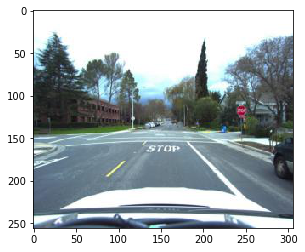

In [48]:
# Front View
image = cv2.imread(os.path.join(example_folder, 'CAM_FRONT.jpeg'))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [49]:
image.shape

(256, 306, 3)

In [50]:
src = np.float32([[75,200], [75,170], [231,200], [231,170]])
#dst306 = np.float32(list(zip([143.5058,136.3664,163.2762,169.9879], [207.3915,187.7969,207.3915,187.7969])))
#dst612 = np.float32(list(zip([286.4787,272.1767,326.0845,339.5298], [414.4597,375.2063,414.4597,375.2063])))
dst = np.float32(list(zip([142.9038,134.7327,163.4615,171.1431], [189.7793,167.3565,189.7793,167.3565])))

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x1083ee940>>
Traceback (most recent call last):
  File "/anaconda3/envs/NLP/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/anaconda3/envs/NLP/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/anaconda3/envs/NLP/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/anaconda3/envs/NLP/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/anaconda3/envs/NLP/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


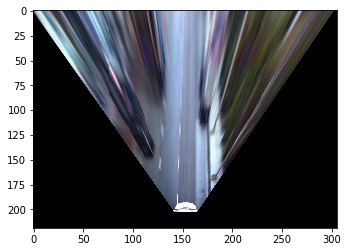

In [43]:
# Keep Width
M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
warped_img = cv2.warpPerspective(image, M, (306,219))
plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))

In [52]:
M

array([[-6.92636526e-02, -1.17089785e+00,  1.64264194e+02],
       [-1.12965193e-14, -1.66944201e+00,  2.34140507e+02],
       [-5.76795556e-17, -7.62799727e-03,  1.00000000e+00]])

In [65]:
img = kornia.image_to_tensor(image)#.permute((2,0,1)) 
img = torch.unsqueeze(img.float(), dim=0) # BxCxHxW
img.shape

torch.Size([1, 3, 256, 306])

In [66]:
img_warp = kornia.warp_perspective(img, torch.tensor(M).float(), dsize=(219, 306))

In [67]:
img_warp.shape

torch.Size([1, 3, 219, 306])

In [69]:
img_warp

tensor([[[[31.7591, 31.9872, 32.5779,  ...,  0.0000,  0.0000,  0.0000],
          [29.9612, 31.2783, 31.9247,  ...,  0.0000,  0.0000,  0.0000],
          [ 6.9901, 31.4952, 31.1589,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[51.0129, 50.7492, 50.5826,  ...,  0.0000,  0.0000,  0.0000],
          [48.2132, 50.7422, 50.7072,  ...,  0.0000,  0.0000,  0.0000],
          [11.3351, 51.1712, 50.6648,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[37.5114, 37.4123, 37.4985,  ...,  0.0000,  0.0000,  0.0000],
          [35.4735, 37.1566, 3

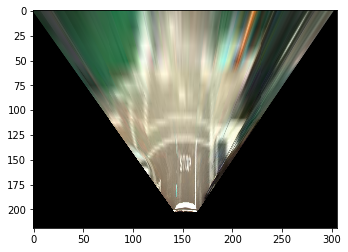

In [68]:
image_warp = kornia.tensor_to_image(img_warp.byte()[0])
plt.imshow(image_warp)

## Front Left View

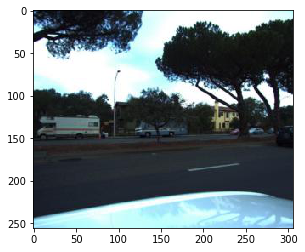

In [11]:
# Front Left View
image = cv2.imread(os.path.join(example_folder, 'CAM_FRONT_LEFT.jpeg'))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [12]:
src = np.float32([[75,200], [75,170], [231,200], [231,170]])
# dst306 = np.float32(list(zip([141.9507,135.0738,161.5291,168.3544], [207.7741,188.4685,207.7741,188.4685])))
# dst612 = np.float32(list(zip([283.3636,269.5872,322.5845,336.2575], [415.2261,376.5516,415.2261,376.5516])))
dst = np.float32(list(zip([143.1914,135.2543,163.7312,171.6087], [189.9223,167.6442,189.9223,167.6442])))

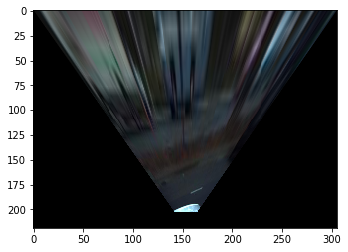

In [13]:
# Keep Width
M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
warped_img = cv2.warpPerspective(image, M, (306,219))
plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))

In [14]:
M

array([[-6.92946073e-02, -1.17143003e+00,  1.64122408e+02],
       [-1.33781874e-14, -1.67019853e+00,  2.34084846e+02],
       [-7.00394603e-17, -7.63146706e-03,  1.00000000e+00]])

## Front Right View

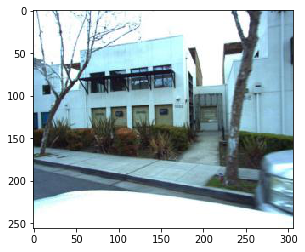

In [15]:
# Front Right View
image = cv2.imread(os.path.join(example_folder, 'CAM_FRONT_RIGHT.jpeg'))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [16]:
src = np.float32([[75,200], [75,170], [231,200], [231,170]])
# dst306 = np.float32(list(zip([145.2979,138.4613,164.7187,171.2574], [207.9535,189.0792,207.9535,189.0792])))
# dst612 = np.float32(list(zip([290.0689 ,276.3733,328.9742,342.0730], [415.5855, 377.7750, 415.5855,377.7750])))
dst = np.float32(list(zip([143.0181,135.0878,163.5252,171.1099], [189.9234,168.0330,189.9234,168.0330])))

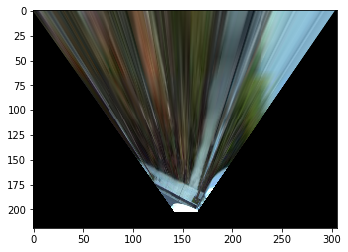

In [17]:
# Keep Width
M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
warped_img = cv2.warpPerspective(image, M, (306,219))
plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))

In [18]:
M

array([[-7.02452787e-02, -1.17762492e+00,  1.64369634e+02],
       [-2.27595720e-14, -1.67903365e+00,  2.34318471e+02],
       [-1.16009632e-16, -7.67182090e-03,  1.00000000e+00]])

## Back View

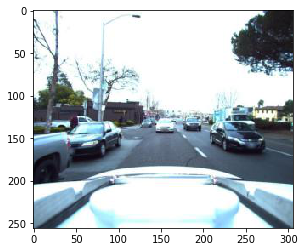

In [19]:
# Back View
image = cv2.imread(os.path.join(example_folder, 'CAM_BACK.jpeg'))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [20]:
src = np.float32([[75,200], [75,170], [231,200], [231,170]])
# dst306 = np.float32(list(zip([144.0169,137.6672,162.7762,168.9471], [208.9258,191.2009,208.9258,191.2009])))
# dst612 = np.float32(list(zip([287.5027,274.7825,325.0828,337.4448], [417.5334,382.0255 ,417.5334,382.0255])))
dst = np.float32(list(zip([143.0091,134.7120,163.6955,171.7590], [189.5869,166.4375,189.5869,166.4375])))

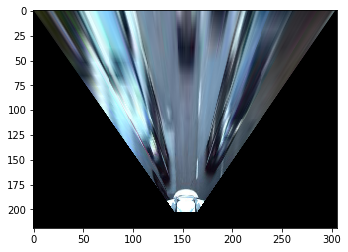

In [23]:
# Keep Width
M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
warped_img = cv2.warpPerspective(image, M, (306,219))
plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))

In [24]:
M

array([[-6.82085369e-02, -1.16228084e+00,  1.64011808e+02],
       [-1.23234756e-14, -1.65715610e+00,  2.33912863e+02],
       [-6.39679282e-17, -7.57186452e-03,  1.00000000e+00]])

## Back Left View

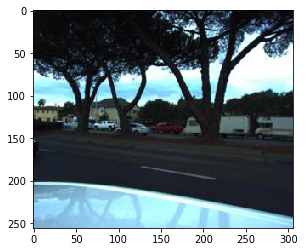

In [25]:
# Back Left View
image = cv2.imread(os.path.join(example_folder, 'CAM_BACK_LEFT.jpeg'))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [26]:
src = np.float32([[75,200], [75,170], [231,200], [231,170]])
# dst306 = np.float32(list(zip([142.5339,136.5759,161.0101,166.9568], [209.3773,192.5555,209.3773,192.5555])))
# dst612 = np.float32(list(zip([284.5319,272.5963,321.5447,333.4577], [418.4378,384.7391,418.4378,384.7391])))
dst = np.float32(list(zip([143.3273,135.6122,163.6534,171.3538], [190.1504,168.3788,190.1504,168.3788])))

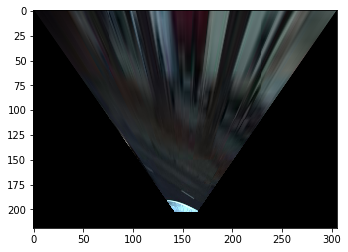

In [27]:
# Keep Width
M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
warped_img = cv2.warpPerspective(image, M, (306,219))
plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))

In [28]:
M

array([[-6.94775392e-02, -1.17675499e+00,  1.64135286e+02],
       [-1.19904087e-14, -1.67779415e+00,  2.34164782e+02],
       [-5.78963960e-17, -7.66615368e-03,  1.00000000e+00]])

## Back Right View

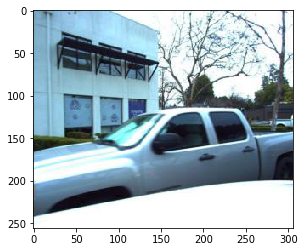

In [29]:
# Back Right View
image = cv2.imread(os.path.join(example_folder, 'CAM_BACK_RIGHT.jpeg'))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [30]:
src = np.float32([[75,200], [75,170], [231,200], [231,170]])
# dst306 = np.float32(list(zip([145.9523,139.8717,164.6983,170.9503], [208.9858,191.5526,208.9858,191.5526])))
# dst612 = np.float32(list(zip([291.3798,279.1988,328.9333,341.4578], [417.6535, 382.7299,417.6535,382.7299])))
dst = np.float32(list(zip([143.3184,135.4043,163.9686,172.1059], [189.6808,167.0022,189.6808,167.0022])))

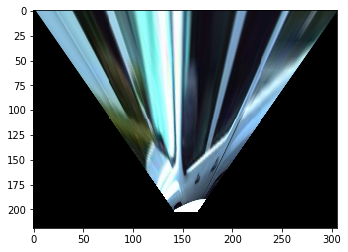

In [31]:
# Keep Width
M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
warped_img = cv2.warpPerspective(image, M, (306,219))
plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))

In [32]:
M

array([[-6.91003275e-02, -1.16814423e+00,  1.63997347e+02],
       [-1.59872116e-14, -1.66551463e+00,  2.34087152e+02],
       [-8.30498864e-17, -7.61006318e-03,  1.00000000e+00]])